In [123]:
%run "Step3.ipynb"

In [124]:
%run "Step4.ipynb"

In [125]:
%run "Step5.ipynb"

C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


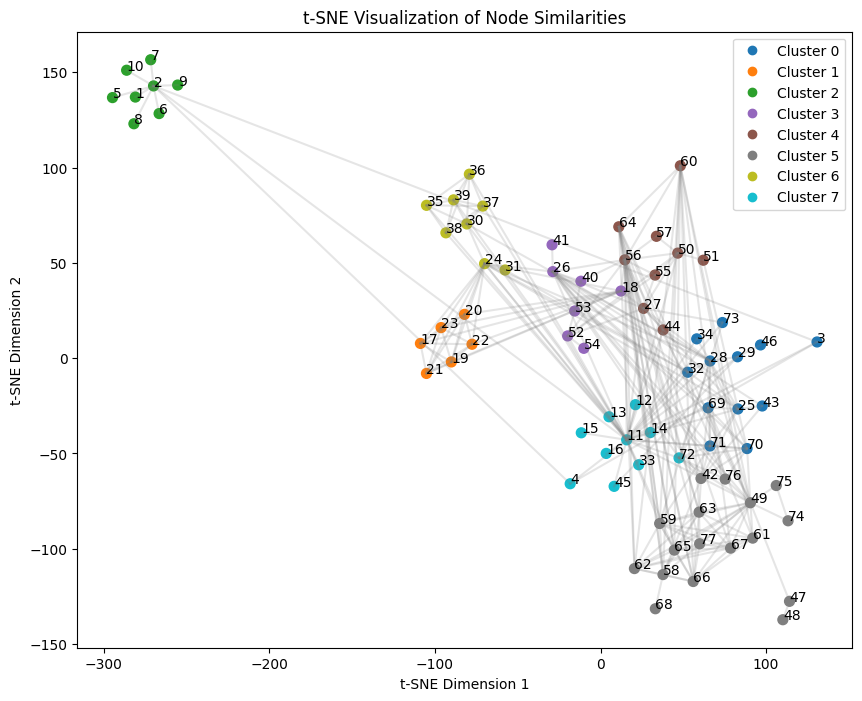

C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explici

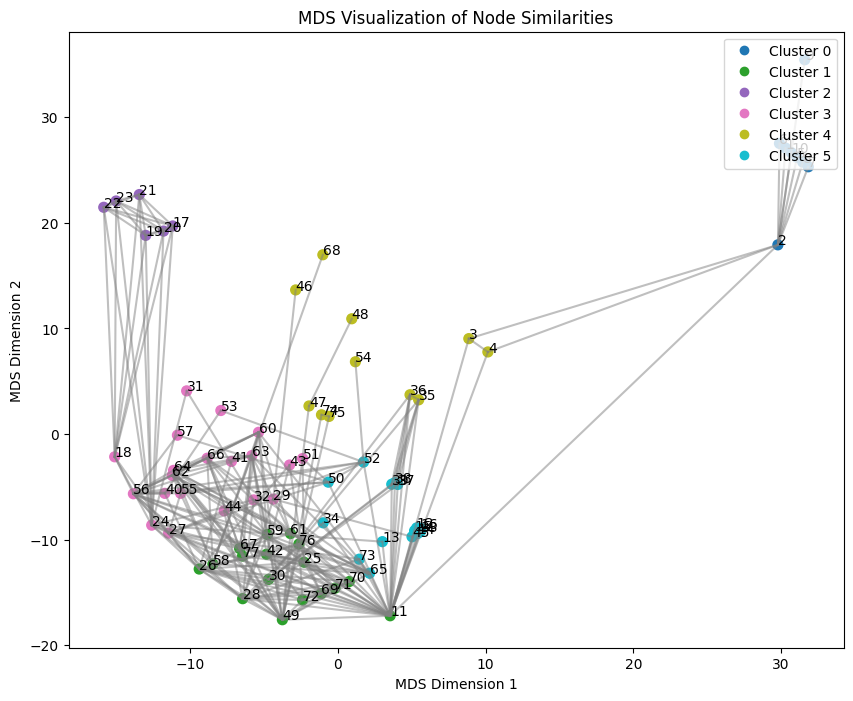

In [126]:
%run "Step6.ipynb"

In [127]:
import statistics

# Graph related metrics

### General Plot

In [128]:
def plot_general_graph(node_positions, edge_list):
    
    size = len(node_positions)/2
    plt.figure(figsize=(size, size))

    for node, coord in node_positions.items():
        color = 'grey' if node.startswith('l') else 'green'
        plt.plot(*coord, marker='o', markersize=30, linestyle='', label='', zorder=2, color=color)  
        if not node.startswith('l'):
            plt.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    for edge in edge_list:
        start = node_positions[edge[0]]
        end = node_positions[edge[1]]
        plt.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1)

    plt.grid(True)
    plt.axis('off')
    plt.show()

### Crossing number

In [129]:
def crossing_number(node_positions, edge_list):

    crossing_number = 0
    crossing_list = []
    for i, edge1 in enumerate(edge_list):
        for edge2 in edge_list[i+1:]:
            crossing = count_crossings(edge1, edge2, node_positions)
            crossing_number += crossing
            if crossing != 0:
                crossing_list.append((edge1,edge2))


    return crossing_number,crossing_list

def count_crossings(edge1, edge2, node_positions):
    x1, y1 = node_positions[edge1[0]] 
    x2, y2 = node_positions[edge1[1]]
    x3, y3 = node_positions[edge2[0]]
    x4, y4 = node_positions[edge2[1]]

    #Vectors 
    dx1 = x2 - x1
    dy1 = y2 - y1
    dx2 = x4 - x3
    dy2 = y4 - y3

    #determinat
    #dx1 dx2
    #dx1 dy2
    #if it's equal to zero means the vectors are collinear, and therefore can not intersect
    divisor = (dx1 * dy2) - (dy1 * dx2)
    if divisor == 0:
        return 0

    #equations solved to t1 and t2, to get the intersections in the report
    t1 = ((x3 - x1) * dy2 - (y3 - y1) * dx2) / divisor
    t2 = ((x3 - x1) * dy1 - (y3 - y1) * dx1) / divisor

    #if this happens, there's an edge crossing between edge1 and edge2
    if 0 < t1 < 1 and 0 < t2 < 1:
        return 1
    else:
        return 0


### Crossing resolution

In [130]:
def crossing_angle(node_positions,P,Q):
    #the angle can be computed by using arccos, but there are two angles involved in a crossing: alpha and PI-angle, and we only want to find the smallest one
    angle1 = math.degrees(math.acos(dot_prod(vector(node_positions,P), vector(node_positions,Q)) / (lenght( vector(node_positions,P)) * lenght( vector(node_positions,Q)))))
    angle2 = abs(angle1-180)
    return min(angle1,angle2)

def crossing_resolution(node_positions, edge_list,crossing_list):
    if crossing_list == []:
        crossing_list = crossing_number(node_positions, edge_list)[1]
    
    angles = []
    min = 360
    ans = ''
    for crossing in crossing_list:
        P,Q = crossing
        angle = crossing_angle(node_positions,P,Q)
        #angles.append(angle)
        if angle <min:
            min = angle
            ans = crossing
    if min != 360:
        return min, ans
    else:
        return 'No crossings'

### Stress of Layout

In [131]:
def stress_layout(node_positions, edge_list,weights={}):
    ans = 0
    node_list = [node for node in node_positions.keys()]
    if weights == {}:
        weights = {edge:1 for edge in edge_list}

    graph_dist = floyd_warshall(node_list, edge_list, weights)
    stress_list = []
    for i,node1 in enumerate(node_list):
        for node2 in node_list[i+1:]:
            dij = graph_dist[node_list.index(node1),node_list.index(node2)]
            if dij != np.inf:
                stress = (distance(node_positions[node1],node_positions[node2])-dij)**2/dij**2
                ans += stress
                stress_list.append(stress)
                
    
    return ans,stress_list               

In [132]:
def stress_layout_norm(node_positions, edge_list,weights={}):
    ans,stress_list = stress_layout(node_positions, edge_list,weights=weights)
    variance =statistics.variance(stress_list)
    return (ans-ans/len(stress_list))/variance

In [133]:
data = [2, 4, 4, 4, 5, 5, 7, 9]
variance = statistics.variance(data)
print("Variance:", type(variance))

Variance: <class 'float'>


### Overall Metrics

In [134]:
# #Setting the coordinates
# node_positions = node_positioning('Datasets/smallnet.dot')
# edge_list = get_data('Datasets/smallnet.dot')[3]

# #Calculating the crossings and plotting the graph
# crossing_num,crossing_list = crossing_number(node_positions, edge_list)
# crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
# stress = stress_layout(node_positions, edge_list)
# #plot_general_graph(node_positions, edge_list)
# print("Crossing number:", crossing_num)
# print("Crossing list:", crossing_list)
# print("Crossing resolution:", crossing_res)
# print('Stress:',stress)

# Applying Layouts

Metrics obtained for the Datasets/smallnet.dot file.
######################################################################
Force Directed Layout
######################################################################
convergence signal!!! 483


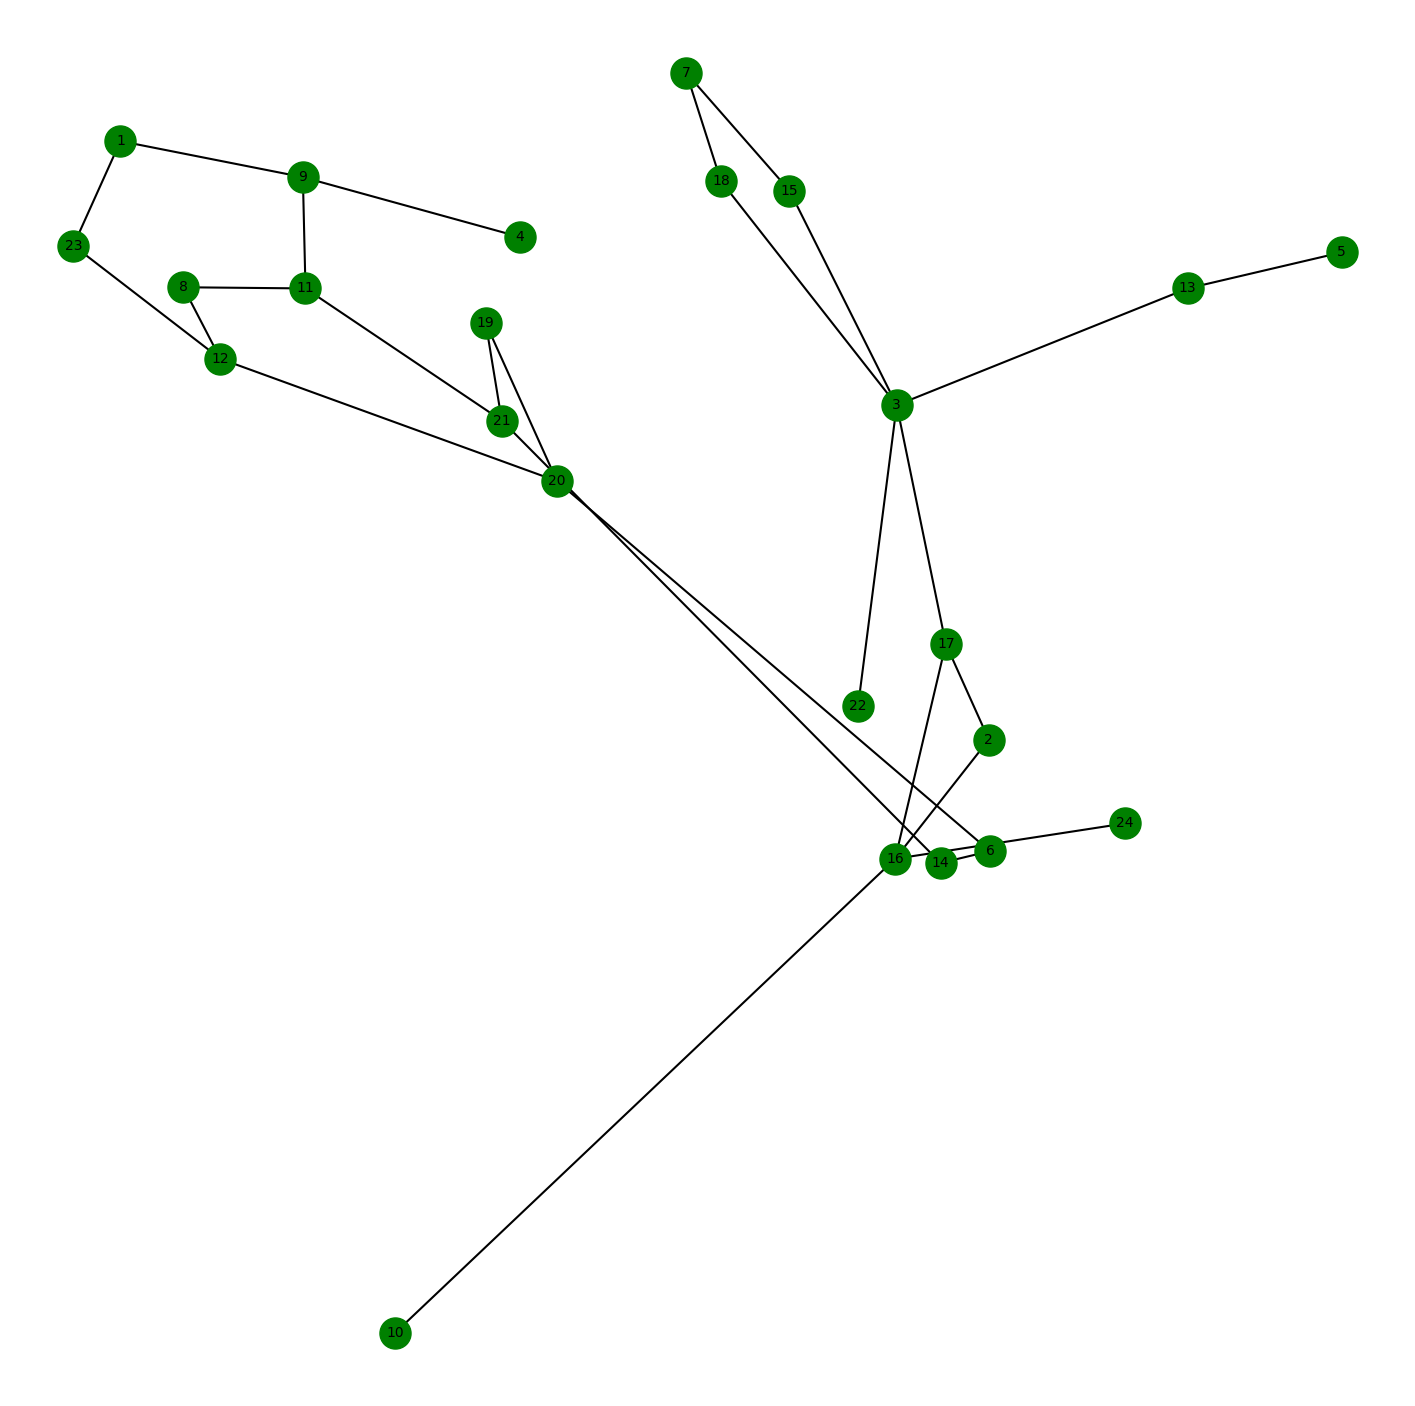

Crossing number: 6
Crossing list: [(('14', '21'), ('16', '2')), (('14', '21'), ('17', '16')), (('14', '21'), ('19', '20')), (('14', '21'), ('20', '6')), (('16', '2'), ('20', '6')), (('17', '16'), ('20', '6'))]
Crossing resolution: (6.54629078329404, (('14', '21'), ('20', '6')))
Stress: 655.319135529191
Stress normalized: 8.219163364292722




######################################################################
Layered Layout
######################################################################




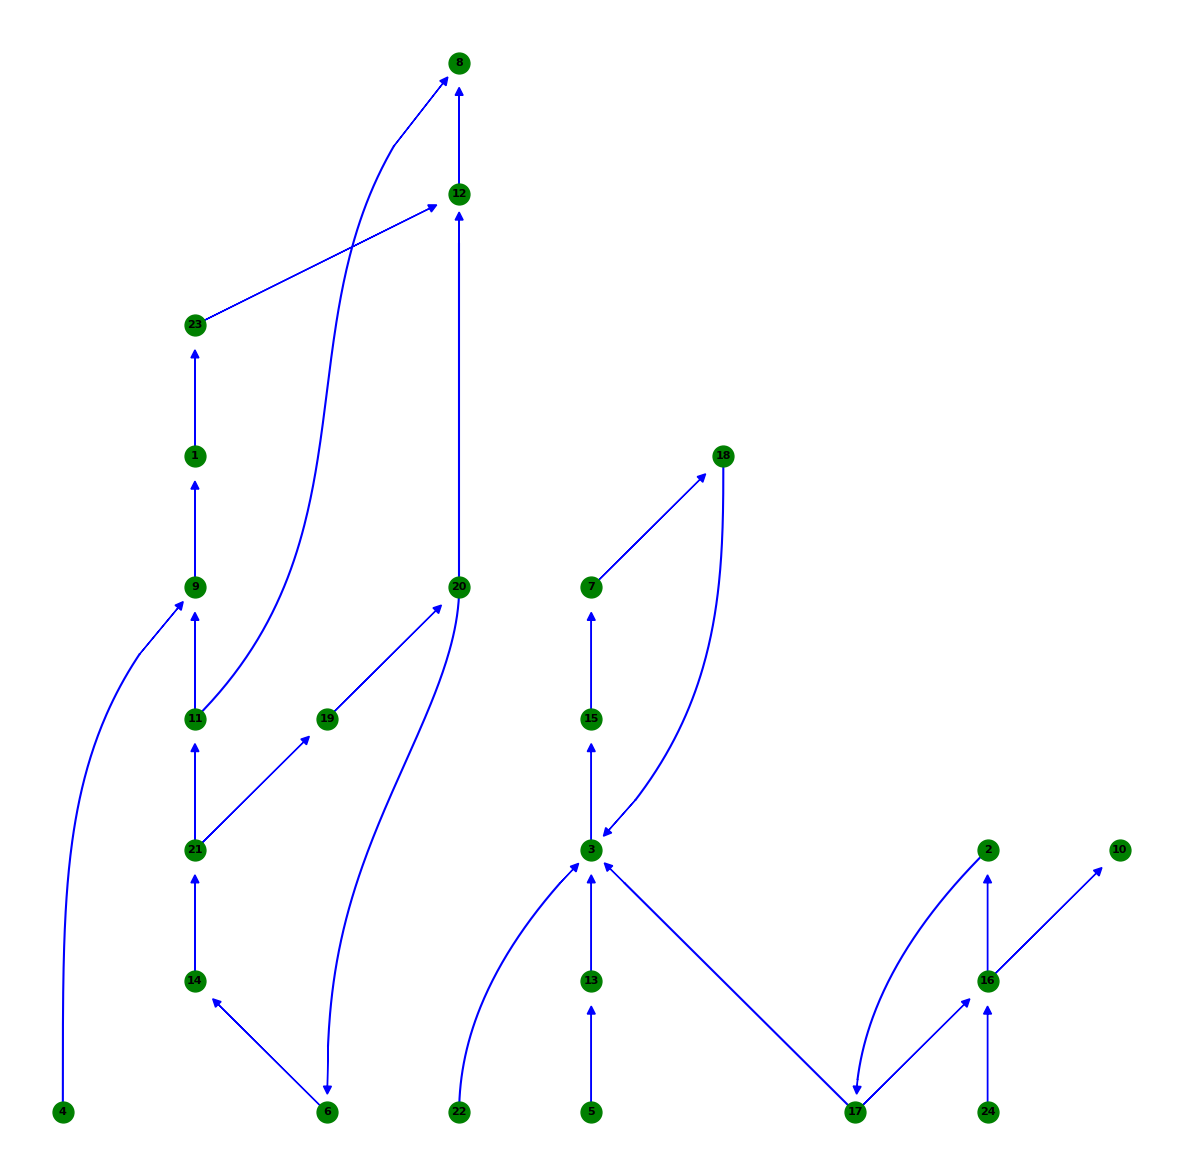

Crossing number: 20
Crossing list: [(('14', '21'), ('16', '10')), (('14', '21'), ('16', '2')), (('14', '21'), ('4', '9')), (('14', '21'), ('2', '17')), (('14', '21'), ('17', '3')), (('14', '21'), ('20', '6')), (('14', '21'), ('22', '3')), (('11', '8'), ('20', '12')), (('11', '8'), ('1', '23')), (('16', '10'), ('4', '9')), (('16', '10'), ('20', '6')), (('4', '9'), ('17', '3')), (('4', '9'), ('20', '6')), (('4', '9'), ('21', '11')), (('4', '9'), ('22', '3')), (('2', '17'), ('22', '3')), (('2', '17'), ('24', '16')), (('17', '3'), ('20', '6')), (('20', '6'), ('21', '11')), (('20', '6'), ('22', '3'))]
Crossing resolution: (22.380135051959567, (('11', '8'), ('20', '12')))
Stress: 137.98871322834964
Stress normalized: 8.219163364292722
Metrics obtained for the Datasets/LesMiserables.dot file.
######################################################################
Force Directed Layout
######################################################################
convergence signal!!! 330


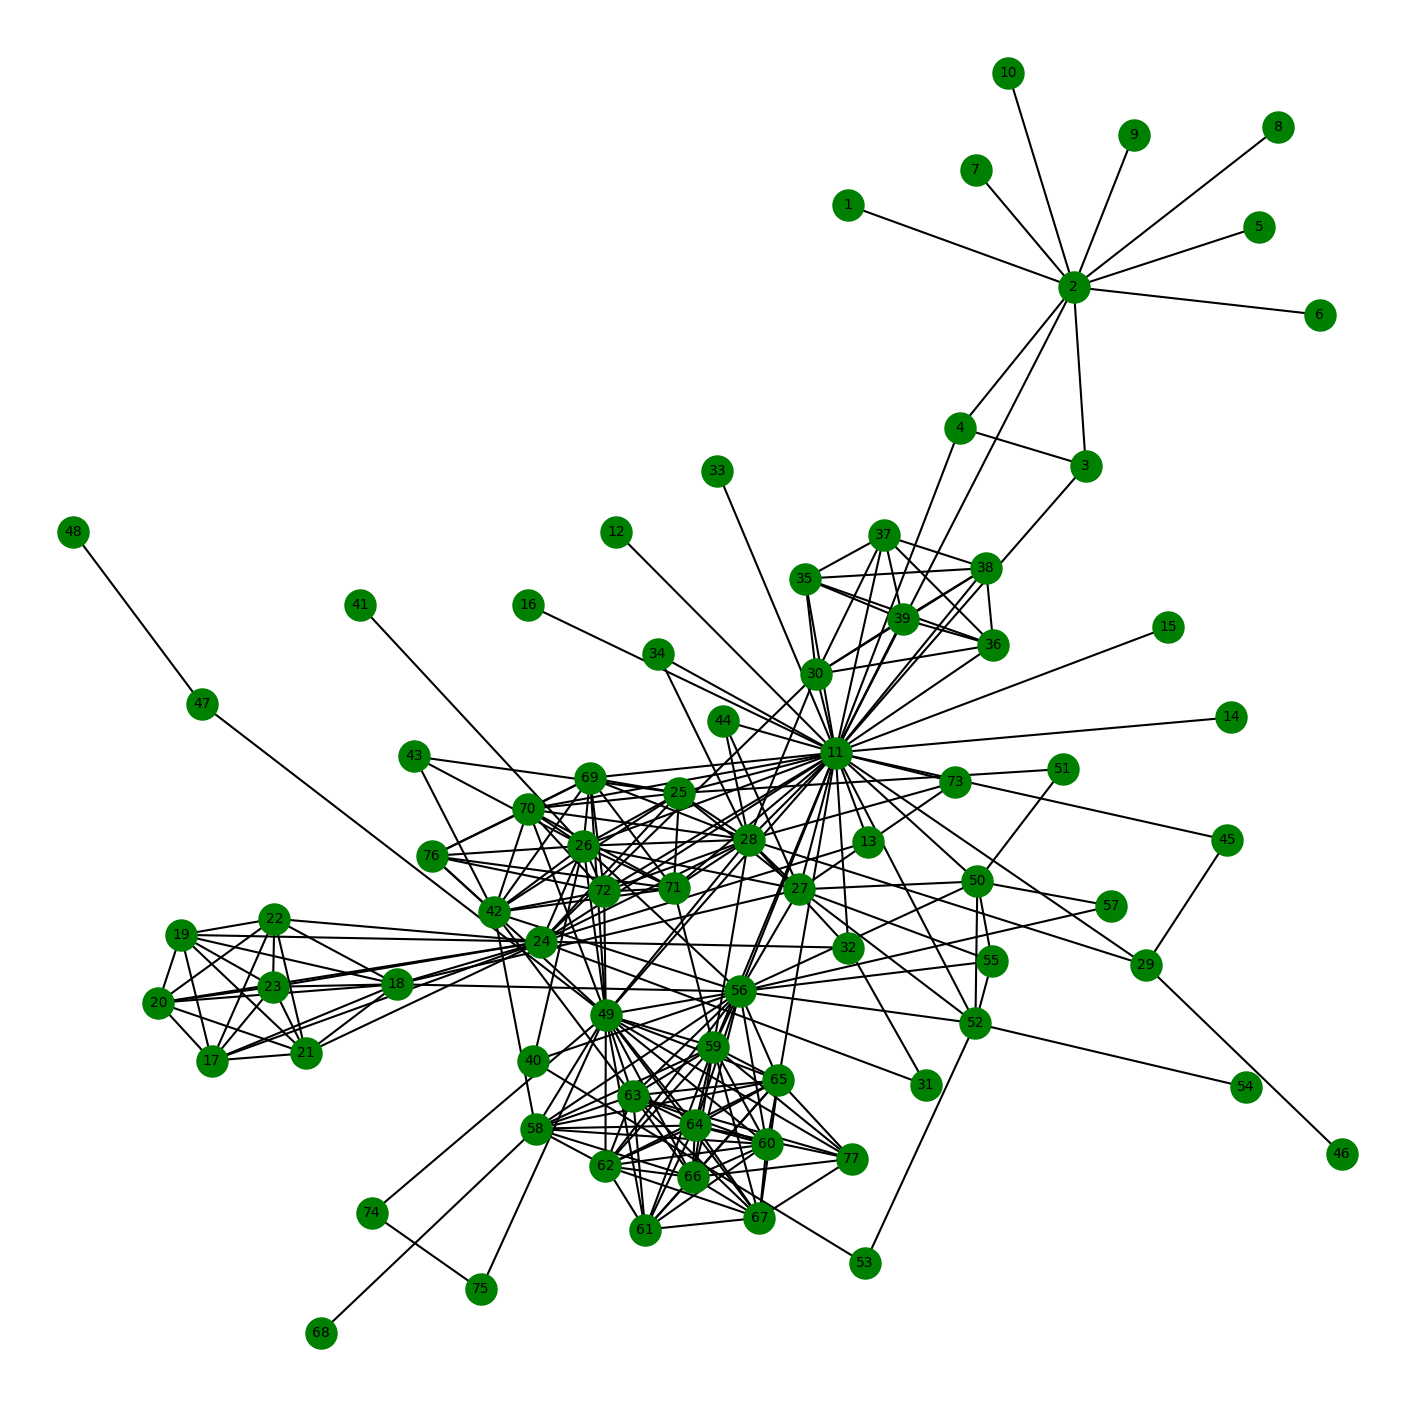

Crossing number: 324
Crossing list: [(('2', '11'), ('3', '4')), (('2', '11'), ('30', '36')), (('2', '11'), ('30', '38')), (('2', '11'), ('35', '36')), (('2', '11'), ('35', '38')), (('2', '11'), ('36', '37')), (('2', '11'), ('36', '39')), (('2', '11'), ('37', '38')), (('2', '11'), ('38', '39')), (('3', '11'), ('30', '36')), (('3', '11'), ('30', '38')), (('3', '11'), ('35', '36')), (('3', '11'), ('35', '38')), (('3', '11'), ('36', '37')), (('3', '11'), ('36', '39')), (('3', '11'), ('37', '38')), (('3', '11'), ('38', '39')), (('4', '11'), ('35', '36')), (('4', '11'), ('35', '38')), (('11', '12'), ('24', '30')), (('11', '12'), ('28', '30')), (('11', '16'), ('24', '30')), (('11', '16'), ('28', '30')), (('11', '24'), ('25', '27')), (('11', '24'), ('25', '28')), (('11', '24'), ('25', '71')), (('11', '24'), ('27', '44')), (('11', '24'), ('28', '30')), (('11', '24'), ('28', '34')), (('11', '24'), ('28', '44')), (('11', '24'), ('28', '69')), (('11', '24'), ('28', '70')), (('11', '24'), ('69', '7

In [139]:
def get_metrics(file,c_spring=2,c_rep=1,l=1, layer=True):
    print('Metrics obtained for the', str(file),'file.')
    #FDL
    print('######################################################################')
    print('Force Directed Layout')
    print('######################################################################')
    #Setting the coordinates
    node_positions_ish = force_directed_layout(file, max_ites=1000,c_spring=c_spring,c_rep=c_rep, l=l,plot='Yes')
    node_positions = {node:(int(coord[0]),int(coord[1])) for node,coord in node_positions_ish.items()}
    edge_list = get_data(file)[3]
    #Calculating the crossings and plotting the graph
    crossing_num,crossing_list = crossing_number(node_positions, edge_list)
    crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
    stress = stress_layout(node_positions, edge_list)[0]
    stress_norm = stress_layout_norm(node_positions, edge_list)
    
    print("Crossing number:", crossing_num)
    print("Crossing list:", crossing_list)
    print("Crossing resolution:", crossing_res)
    print('Stress:',stress)
    print('Stress normalized:',stress_norm)
    print('\n')
    print('\n')
    print('######################################################################')

    if layer:
        print('Layered Layout')

        print('######################################################################')
        print('\n')

        #Setting the coordinates
        node_positions = get_layer_assignment(file)
            
        edge_list = get_data(file)[3]

        #Calculating the crossings and plotting the graph
        crossing_num,crossing_list = crossing_number(node_positions, edge_list)
        crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
        stress = stress_layout(node_positions, edge_list)[0]
        edge_drawing_plot(file,dif_color='blue')
        #plot_general_graph(node_positions, edge_list)
        print("Crossing number:", crossing_num)
        print("Crossing list:", crossing_list)
        print("Crossing resolution:", crossing_res)
        print('Stress:',stress)
        print('Stress normalized:',stress_norm)



get_metrics('Datasets/smallnet.dot')
get_metrics('Datasets/LesMiserables.dot', c_spring=6, c_rep=1, l=1)
get_metrics('Datasets/JazzNetwork.dot', c_spring=2, c_rep=1, l=1)
get_metrics('Datasets/LeaugeNetwork.dot', layer=False)



## Small Net

### FDL

convergence signal!!! 309


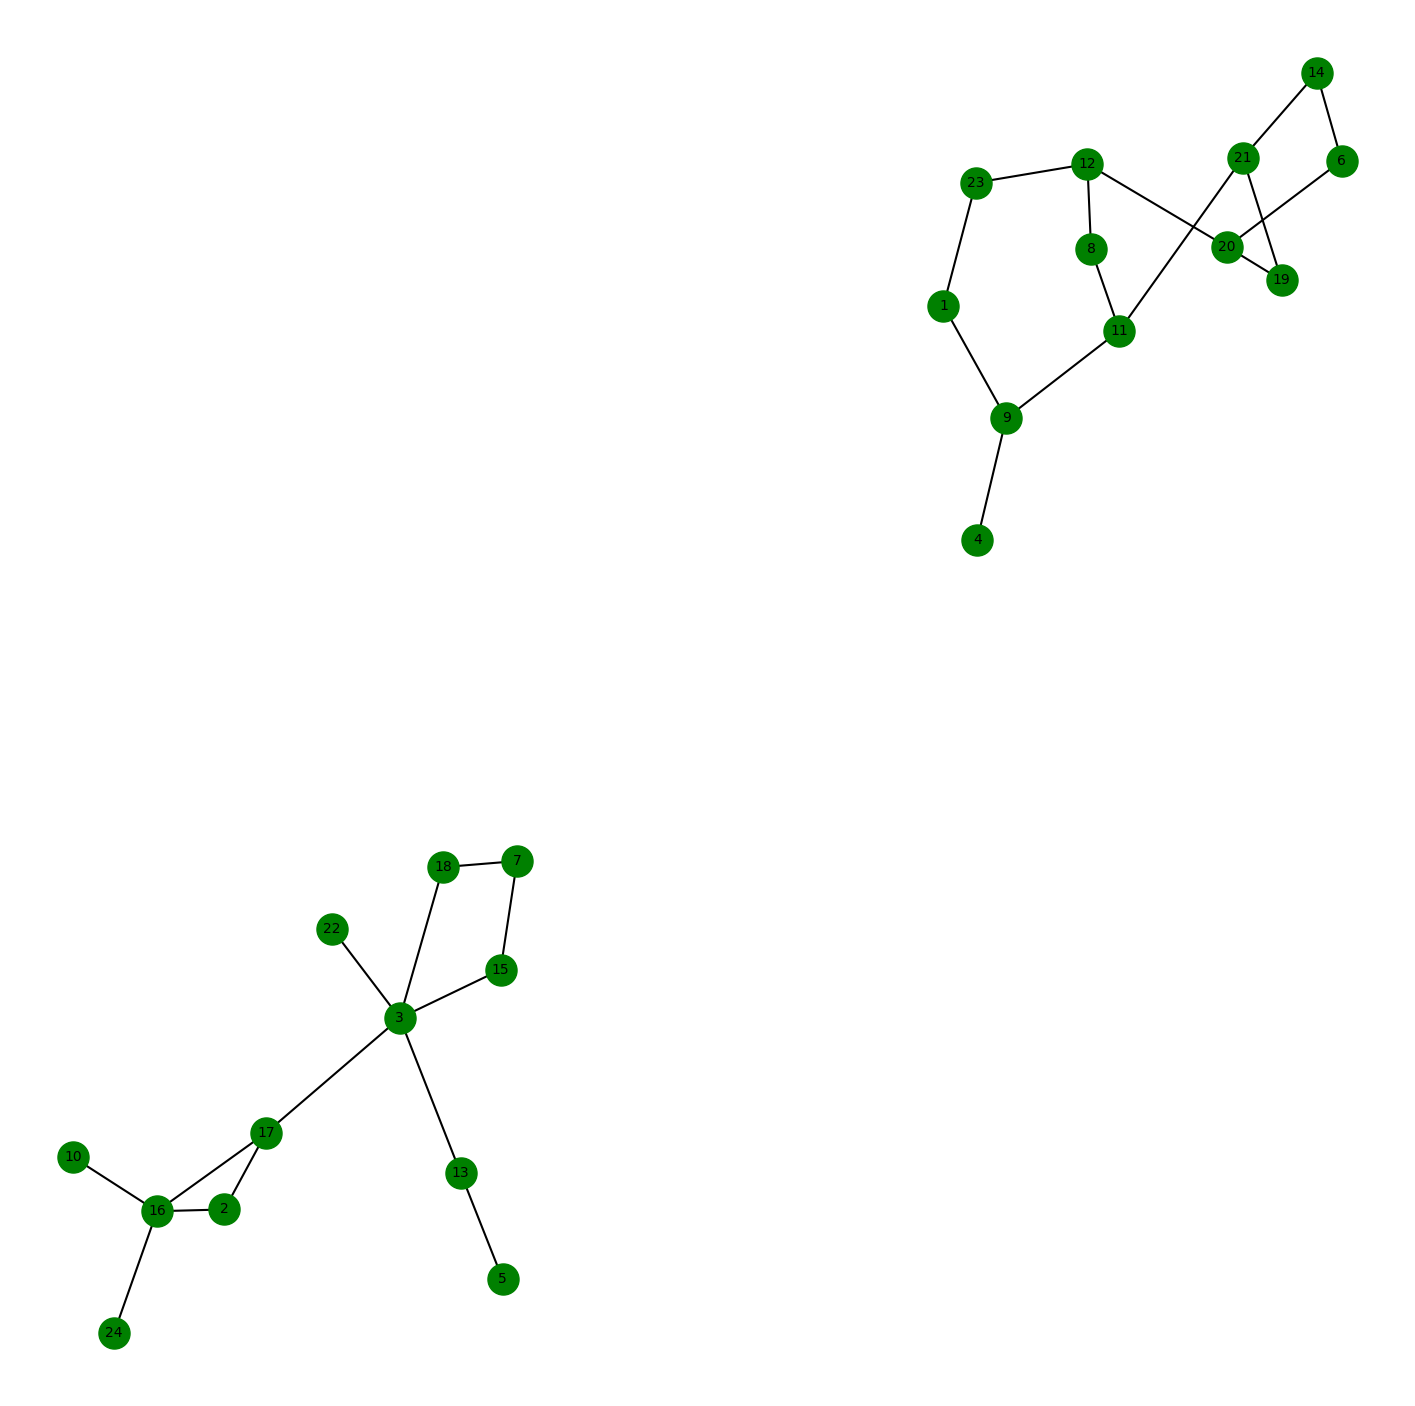

Crossing number: 2
Crossing list: [(('20', '12'), ('21', '11')), (('20', '6'), ('21', '19'))]
Crossing resolution: (71.56505117707799, (('20', '12'), ('21', '11')))
Stress: 64.05646757218788


In [136]:
#Setting the coordinates
node_positions_ish = force_directed_layout('Datasets/smallnet.dot', max_ites=1000,c_spring=6,c_rep=5, l=1,plot='Yes')
node_positions = {node:(int(coord[0]),int(coord[1])) for node,coord in node_positions_ish.items()}
edge_list = get_data('Datasets/smallnet.dot')[3]

#Calculating the crossings and plotting the graph
crossing_num,crossing_list = crossing_number(node_positions, edge_list)
crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
stress = stress_layout(node_positions, edge_list)[0]

print("Crossing number:", crossing_num)
print("Crossing list:", crossing_list)
print("Crossing resolution:", crossing_res)
print('Stress:',stress)

### Layered

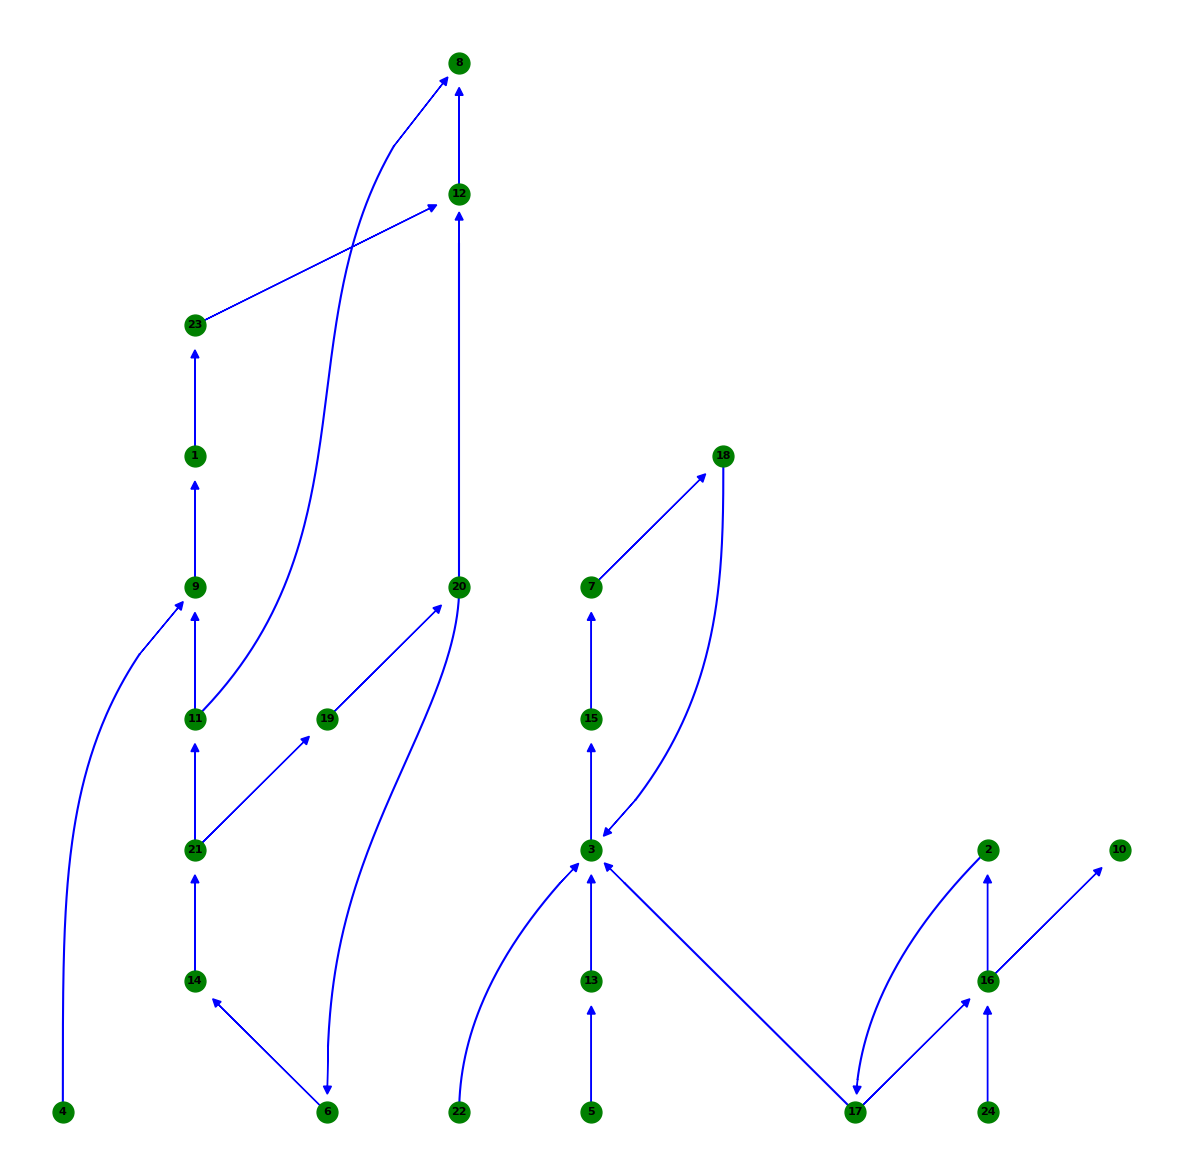

Crossing number: 1
Crossing list: [(('11', '8'), ('23', '12'))]
Crossing resolution: (41.63353933657021, (('11', '8'), ('23', '12')))
Stress: 103.9424027789127


In [137]:
#Setting the coordinates
node_positions = node_positioning('Datasets/smallnet.dot')
edge_list = get_data('Datasets/smallnet.dot')[3]

#Calculating the crossings and plotting the graph
crossing_num,crossing_list = crossing_number(node_positions, edge_list)
crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
stress = stress_layout(node_positions, edge_list)[0]
edge_drawing_plot('Datasets/smallnet.dot',dif_color='blue')
#plot_general_graph(node_positions, edge_list)
print("Crossing number:", crossing_num)
print("Crossing list:", crossing_list)
print("Crossing resolution:", crossing_res)
print('Stress:',stress)

### Projection

## Les Miserables

### Force Directed Layout

In [138]:
FDL_Mis = force_directed_layout('Datasets/LesMiserables.dot', max_ites=1000,c_spring=6,c_rep=5, l=1,convergence_threshold=0,plot='Yes')
#convergence_threshold=0.0005

KeyboardInterrupt: 

In [ ]:
#Setting the coordinates
node_positions_ish = FDL_Mis
node_positions = {node:(int(coord[0]),int(coord[1])) for node,coord in node_positions_ish.items()}
edge_list = get_data('Datasets/LesMiserables.dot')[3]

#Calculating the crossings and plotting the graph
crossing_num,crossing_list = crossing_number(node_positions, edge_list)
crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
stress = stress_layout(node_positions, edge_list)[0]

print("Crossing number:", crossing_num)
print("Crossing list:", crossing_list)
print("Crossing resolution:", crossing_res)
print('Stress:',stress)

Crossing number: 510
Crossing list: [(('2', '11'), ('24', '26')), (('2', '11'), ('24', '28')), (('2', '11'), ('27', '44')), (('2', '11'), ('27', '56')), (('2', '11'), ('28', '32')), (('2', '11'), ('29', '46')), (('2', '11'), ('56', '18')), (('2', '11'), ('56', '57')), (('3', '11'), ('24', '26')), (('3', '11'), ('24', '28')), (('3', '11'), ('27', '44')), (('3', '11'), ('27', '56')), (('3', '11'), ('28', '32')), (('3', '11'), ('56', '18')), (('3', '11'), ('56', '57')), (('4', '11'), ('24', '26')), (('4', '11'), ('24', '28')), (('4', '11'), ('27', '44')), (('4', '11'), ('27', '56')), (('4', '11'), ('28', '32')), (('4', '11'), ('56', '18')), (('4', '11'), ('56', '57')), (('11', '12'), ('24', '30')), (('11', '12'), ('26', '40')), (('11', '12'), ('28', '73')), (('11', '12'), ('50', '56')), (('11', '12'), ('52', '56')), (('11', '12'), ('56', '40')), (('11', '13'), ('27', '44')), (('11', '13'), ('27', '56')), (('11', '13'), ('50', '57')), (('11', '14'), ('24', '25')), (('11', '14'), ('24', '30

### Layered Layout

The layered layout doesn't make sense for the League Network, given that this dataset is not a directed network

In [ ]:
#plot_cross_min('Datasets/LesMiserables.dot',heur='bary')
#edge_drawing_plot('Datasets/LesMiserables.dot',dif_color='blue',ite = 1)
#plot_layer_assignment('Datasets/LesMiserables.dot')

### Projection

## Jazz Network

### Force Directed Layout

In [ ]:
FDL_Jazz = force_directed_layout('Datasets/JazzNetwork.dot', max_ites=1000,c_spring=6,c_rep=5, l=1,plot='Yes')

In [ ]:
#Setting the coordinates
node_positions_ish = FDL_Jazz
node_positions = {node:(int(coord[0]),int(coord[1])) for node,coord in node_positions_ish.items()}
edge_list = get_data('Datasets/JazzNetwork.dot')[3]

#Calculating the crossings and plotting the graph
crossing_num,crossing_list = crossing_number(node_positions, edge_list)
crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
stress = stress_layout(node_positions, edge_list)[0]

print("Crossing number:", crossing_num)
print("Crossing list:", crossing_list)
print("Crossing resolution:", crossing_res)
print('Stress:',stress)

### Layer Layout

The layered layout doesn't make sense for the League Network, given that this dataset is not a directed network

In [ ]:
#plot_layer_assignment('Datasets/JazzNetwork.dot')
#edge_drawing_plot('Datasets/JazzNetwork.dot',dif_color='blue',ite = 1)
#plot_layer_assignment('Datasets/JazzNetwork.dot')

### Projection

## League Network

### Force Directed Layout

In [ ]:
FDL_League = force_directed_layout('Datasets/LeagueNetwork.dot', plot='Yes')

In [ ]:
#Setting the coordinates
node_positions_ish = FDL_League 
node_positions = {node:(int(coord[0]),int(coord[1])) for node,coord in node_positions_ish.items()}
edge_list = get_data('Datasets/LeagueNetwork.dot')[3]

#Calculating the crossings and plotting the graph
crossing_num,crossing_list = crossing_number(node_positions, edge_list)
crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
stress = stress_layout(node_positions, edge_list)[0]

print("Crossing number:", crossing_num)
print("Crossing list:", crossing_list)
print("Crossing resolution:", crossing_res)
print('Stress:',stress)

In [ ]:
FDL_League_Pos = force_directed_layout('Datasets/XPos_LeagueNetwork.dot',plot='Yes')

In [ ]:
#Setting the coordinates
node_positions_ish = FDL_League_Pos
node_positions = {node:(int(coord[0]),int(coord[1])) for node,coord in node_positions_ish.items()}
edge_list = get_data('Datasets/XPos_LeagueNetwork.dot')[3]

#Calculating the crossings and plotting the graph
crossing_num,crossing_list = crossing_number(node_positions, edge_list)
crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
stress = stress_layout(node_positions, edge_list)[0]

print("Crossing number:", crossing_num)
print("Crossing list:", crossing_list)
print("Crossing resolution:", crossing_res)
print('Stress:',stress)

In [ ]:
FDL_League_Zero = force_directed_layout('Datasets/XZero_LeagueNetwork.dot', plot='Yes')

In [ ]:
#Setting the coordinates
node_positions_ish = FDL_League_Zero
node_positions = {node:(int(coord[0]),int(coord[1])) for node,coord in node_positions_ish.items()}
edge_list = get_data('Datasets/XZero_LeagueNetwork.dot')[3]

#Calculating the crossings and plotting the graph
crossing_num,crossing_list = crossing_number(node_positions, edge_list)
crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
stress = stress_layout(node_positions, edge_list)[0]

print("Crossing number:", crossing_num)
print("Crossing list:", crossing_list)
print("Crossing resolution:", crossing_res)
print('Stress:',stress)

In [ ]:
FDL_League_Neg = force_directed_layout('Datasets/XNeg_LeagueNetwork.dot',plot='Yes')

In [ ]:
#Setting the coordinates
node_positions_ish = FDL_League_Neg
node_positions = {node:(int(coord[0]),int(coord[1])) for node,coord in node_positions_ish.items()}
edge_list = get_data('Datasets/XNeg_LeagueNetwork.dot')[3]

#Calculating the crossings and plotting the graph
crossing_num,crossing_list = crossing_number(node_positions, edge_list)
crossing_res = crossing_resolution(node_positions, edge_list,crossing_list)
stress = stress_layout(node_positions, edge_list)[0]

print("Crossing number:", crossing_num)
print("Crossing list:", crossing_list)
print("Crossing resolution:", crossing_res)
print('Stress:',stress)

### Layer Layout

In [ ]:
#plot_layer_assignment('Datasets/LeagueNetwork.dot')
edge_drawing_plot('Datasets/LeagueNetwork.dot',dif_color='blue',ite = 1)

### Projection

In [ ]:
# plot_layer_assignment('XNeg_LeagueNetwork.dot')
# plot_layer_assignment('XZero_LeagueNetwork.dot')
# plot_layer_assignment('XPos_LeagueNetwork.dot')